In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib import cm
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
sns.set(style="whitegrid")
plt.rcParams['figure.dpi'] = 110

df = pd.read_csv("/kaggle/input/forest-cover-type/covtype.csv")

In [2]:
def preprocess_covtype_universal(df):
    import numpy as np
    import pandas as pd
    from sklearn.preprocessing import StandardScaler

    print("============== 1. INITIAL DATASET SHAPE ==============")
    print(df.shape)

    df = df.copy()

    # ------------------------------------------------------
    # 2. REMOVE DUPLICATES
    # ------------------------------------------------------
    print("\n============== 2. DUPLICATE REMOVAL ==============")
    before = df.shape[0]
    df = df.drop_duplicates().copy()
    after = df.shape[0]
    print(f"Removed {before - after} duplicates")

    # ------------------------------------------------------
    # 3. HANDLE MISSING VALUES (Not expected but safe)
    # ------------------------------------------------------
    print("\n============== 3. MISSING VALUE IMPUTATION ==============")
    for col in df.columns:
        df[col] = df[col].fillna(df[col].median())
    print("Missing values handled.")

    # ------------------------------------------------------
    # 4. IDENTIFY NUMERIC & BINARY COLUMNS
    # ------------------------------------------------------
    print("\n============== 4. COLUMN TYPES ==============")

    num_cols = [
        'Elevation', 'Aspect', 'Slope',
        'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
        'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points',
        'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm'
    ]

    bin_cols = [c for c in df.columns if c.startswith("Wilderness") or c.startswith("Soil")]

    target_col = "Cover_Type"

    print("Numeric Columns:", num_cols)
    print("Binary Columns:", len(bin_cols))
    print("Target Column:", target_col)

    # ------------------------------------------------------
    # 5. OUTLIER DETECTION & REMOVAL (IQR, <15% rule)
    # ------------------------------------------------------
    print("\n============== 5. OUTLIER ANALYSIS (IQR METHOD) ==============")

    outlier_rows = set()

    for col in num_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        mask = (df[col] < lower) | (df[col] > upper)
        ratio = mask.mean()

        print(f"{col}: {ratio*100:.2f}% outliers")

        if ratio < 0.15:
            outlier_rows.update(df[mask].index)

    print(f"\nTotal removable outliers: {len(outlier_rows)}")

    df = df.drop(index=outlier_rows).reset_index(drop=True)

    print("Dataset shape after outlier removal:", df.shape)

    # ------------------------------------------------------
    # 6. SCALING (StandardScaler only on numerical columns)
    # ------------------------------------------------------
    print("\n============== 6. FEATURE SCALING (StandardScaler) ==============")

    scaler = StandardScaler()
    df[num_cols] = scaler.fit_transform(df[num_cols])

    print("Scaling completed.")

    # ------------------------------------------------------
    # FINAL SUMMARY
    # ------------------------------------------------------
    print("\n============== FINAL DATASET SUMMARY ==============")
    print("Final Shape:", df.shape)
    print("Total Columns:", len(df.columns))

    return df, scaler, num_cols, bin_cols, outlier_rows
df_processed, scaler, num_cols, bin_cols, outliers = preprocess_covtype_universal(df)

============== 1. INITIAL DATASET SHAPE ==============
(581012, 55)

============== 2. DUPLICATE REMOVAL ==============
Removed 0 duplicates

============== 3. MISSING VALUE IMPUTATION ==============
Missing values handled.

============== 4. COLUMN TYPES ==============
Numeric Columns: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm']
Binary Columns: 44
Target Column: Cover_Type

============== 5. OUTLIER ANALYSIS (IQR METHOD) ==============
Elevation: 2.68% outliers
Aspect: 0.00% outliers
Slope: 2.64% outliers
Horizontal_Distance_To_Hydrology: 2.51% outliers
Vertical_Distance_To_Hydrology: 5.42% outliers
Horizontal_Distance_To_Roadways: 0.12% outliers
Horizontal_Distance_To_Fire_Points: 5.36% outliers
Hillshade_9am: 3.00% outliers
Hillshade_Noon: 2.70% outliers
Hillshade_3pm: 1.35% outliers

Total removable o

# EDA

In [3]:
df = df_processed   # outlier-removed + scaled dataset

num_cols = [
    'Elevation', 'Aspect', 'Slope',
    'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
    'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points',
    'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm'
]

wild_cols  = [col for col in df.columns if col.startswith("Wilderness")]
soil_cols  = [col for col in df.columns if col.startswith("Soil")]
target_col = "Cover_Type"


## Plot 1 — Class Distribution

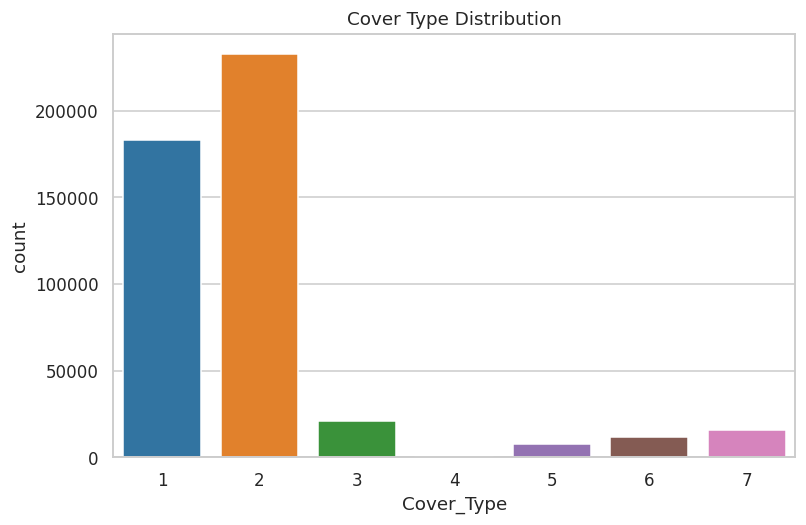

In [4]:
plt.figure(figsize=(8,5))
palette = sns.color_palette("tab10", 7)
sns.countplot(x=df[target_col], palette=palette)
plt.title("Cover Type Distribution")
plt.show()


# Plot 2 — Numerical Feature Histograms

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

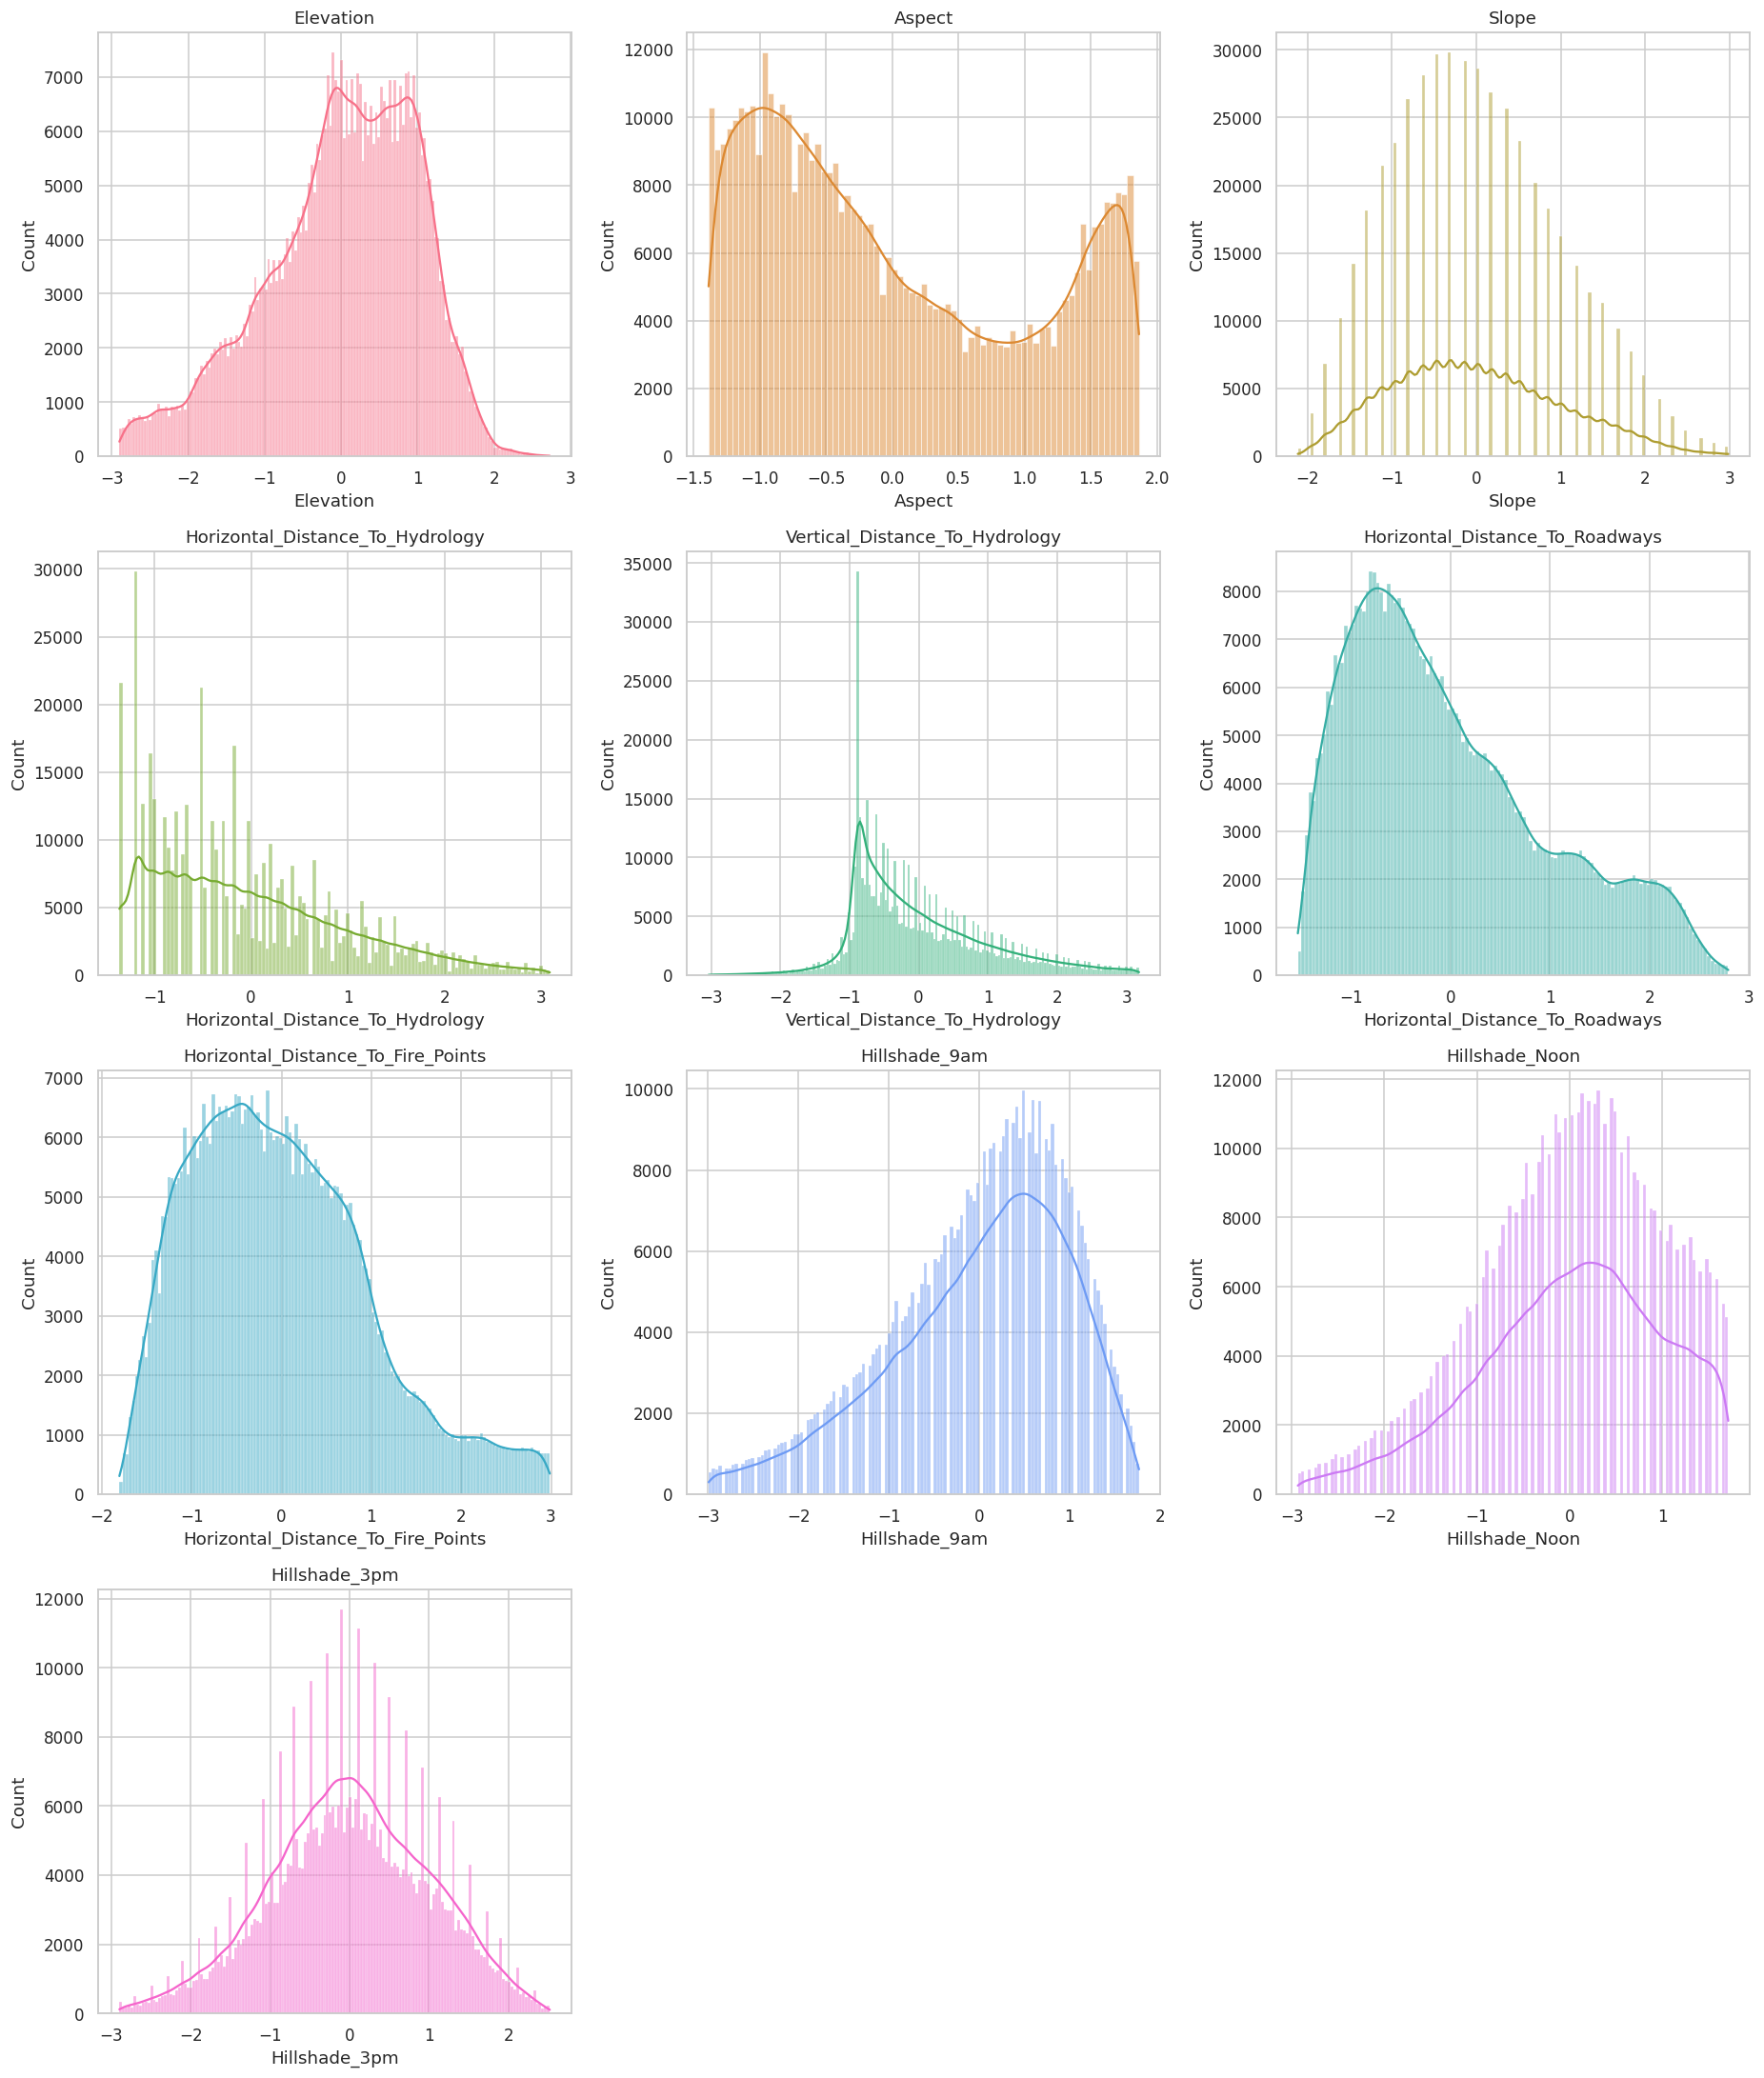

In [5]:
import math

n = len(num_cols)
rows = math.ceil(n / 3)

plt.figure(figsize=(17, 5 * rows))

for i, col in enumerate(num_cols, 1):
    plt.subplot(rows, 3, i)
    sns.histplot(df[col], kde=True, color=sns.color_palette("husl", n)[i-1])
    plt.title(col)

plt.tight_layout()
plt.show()


## Plot 3 — Correlation Heatmap

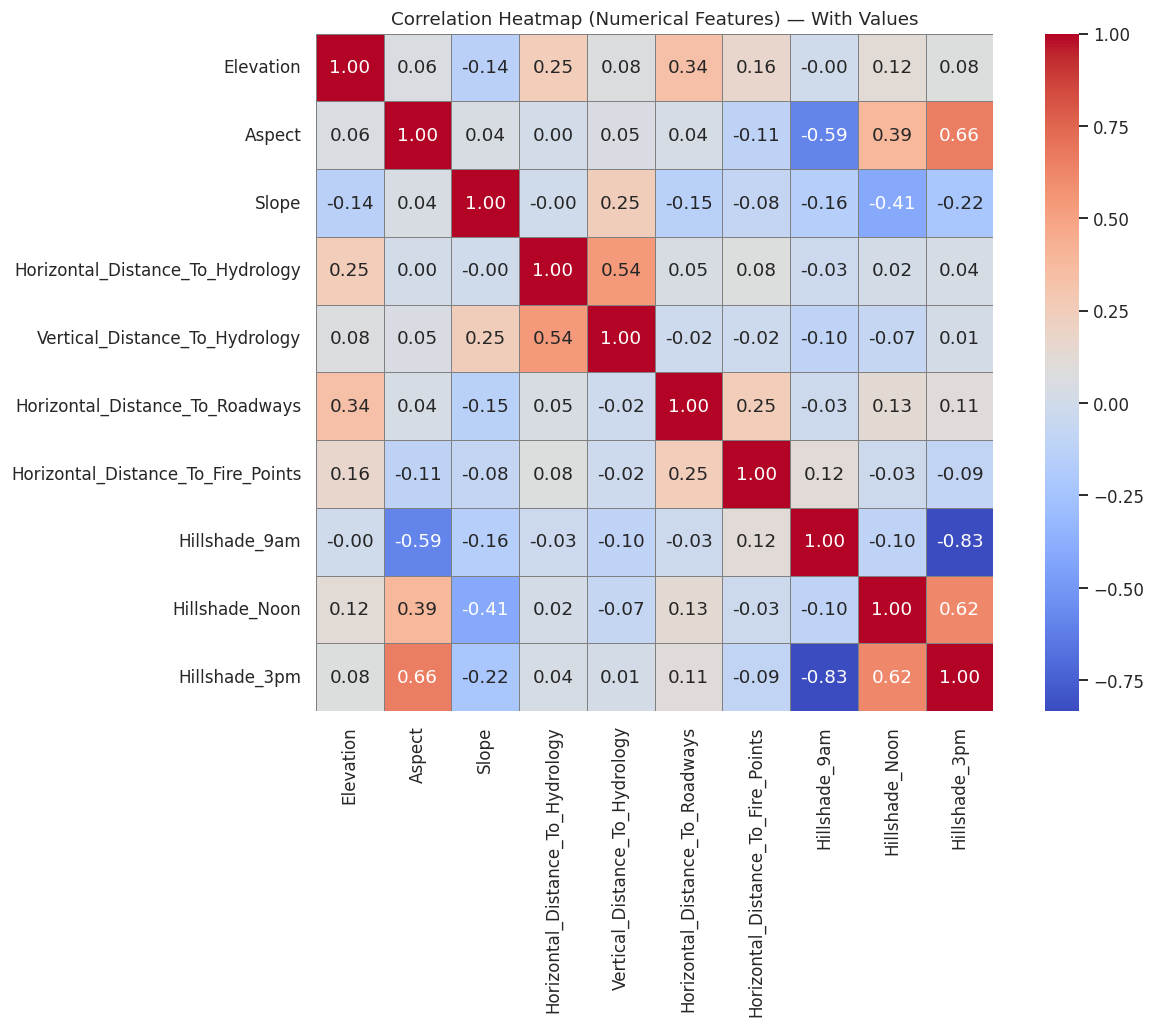

In [6]:
plt.figure(figsize=(12,8))

corr_matrix = df[num_cols].corr()

sns.heatmap(
    corr_matrix,
    cmap="coolwarm",
    annot=True,          # <-- SHOW VALUES
    fmt=".2f",           # <-- LIMIT TO 2 DECIMALS
    linewidths=0.5,
    linecolor='gray',
    cbar=True,
    square=True
)

plt.title("Correlation Heatmap (Numerical Features) — With Values")
plt.show()


## Plot 4 — Elevation vs Cover_Type Boxplot

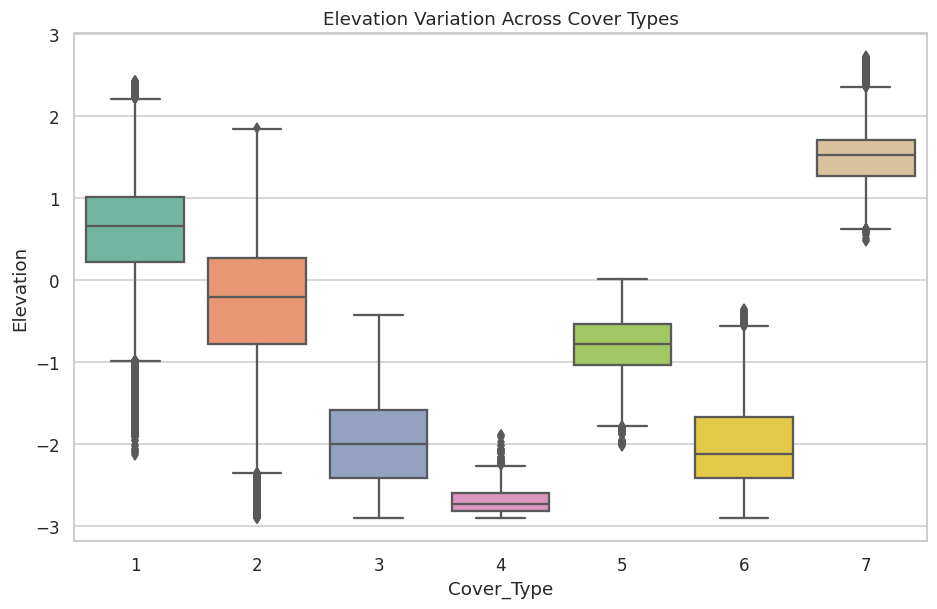

In [7]:
plt.figure(figsize=(10,6))
sns.boxplot(x=df[target_col], y=df["Elevation"], palette="Set2")
plt.title("Elevation Variation Across Cover Types")
plt.show()


## Plot 6 — Wilderness Area Frequency

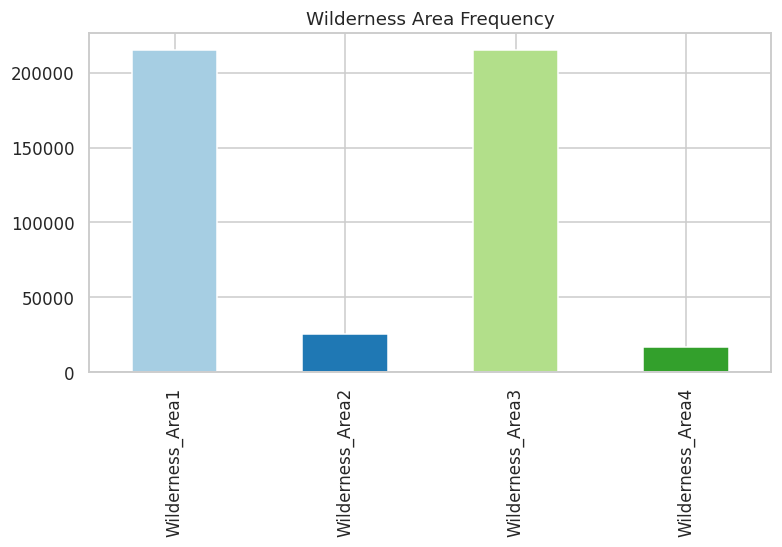

In [8]:
plt.figure(figsize=(8,4))
df[wild_cols].sum().plot(kind="bar", color=sns.color_palette("Paired"))
plt.title("Wilderness Area Frequency")
plt.show()

## Plot 7 — Soil Type Frequency

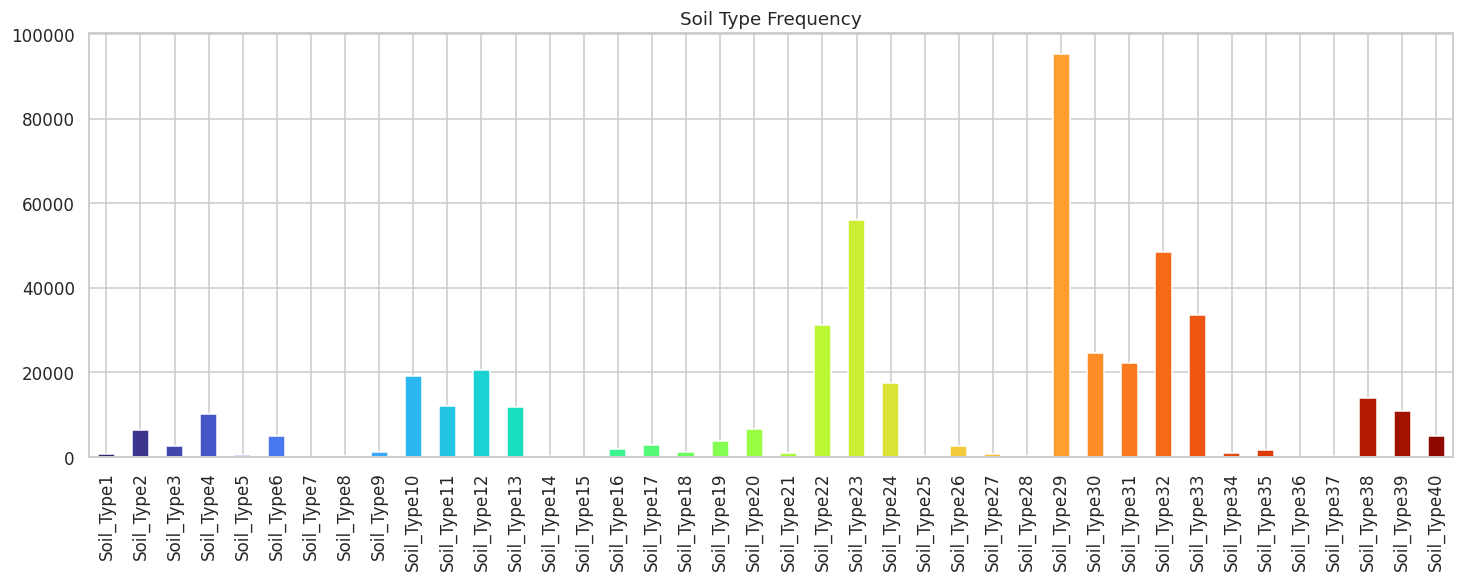

In [9]:
plt.figure(figsize=(16,5))
df[soil_cols].sum().plot(kind="bar", color=sns.color_palette("turbo", len(soil_cols)))
plt.title("Soil Type Frequency")
plt.show()

## Plot 8 — Boxplots of All Numeric Features

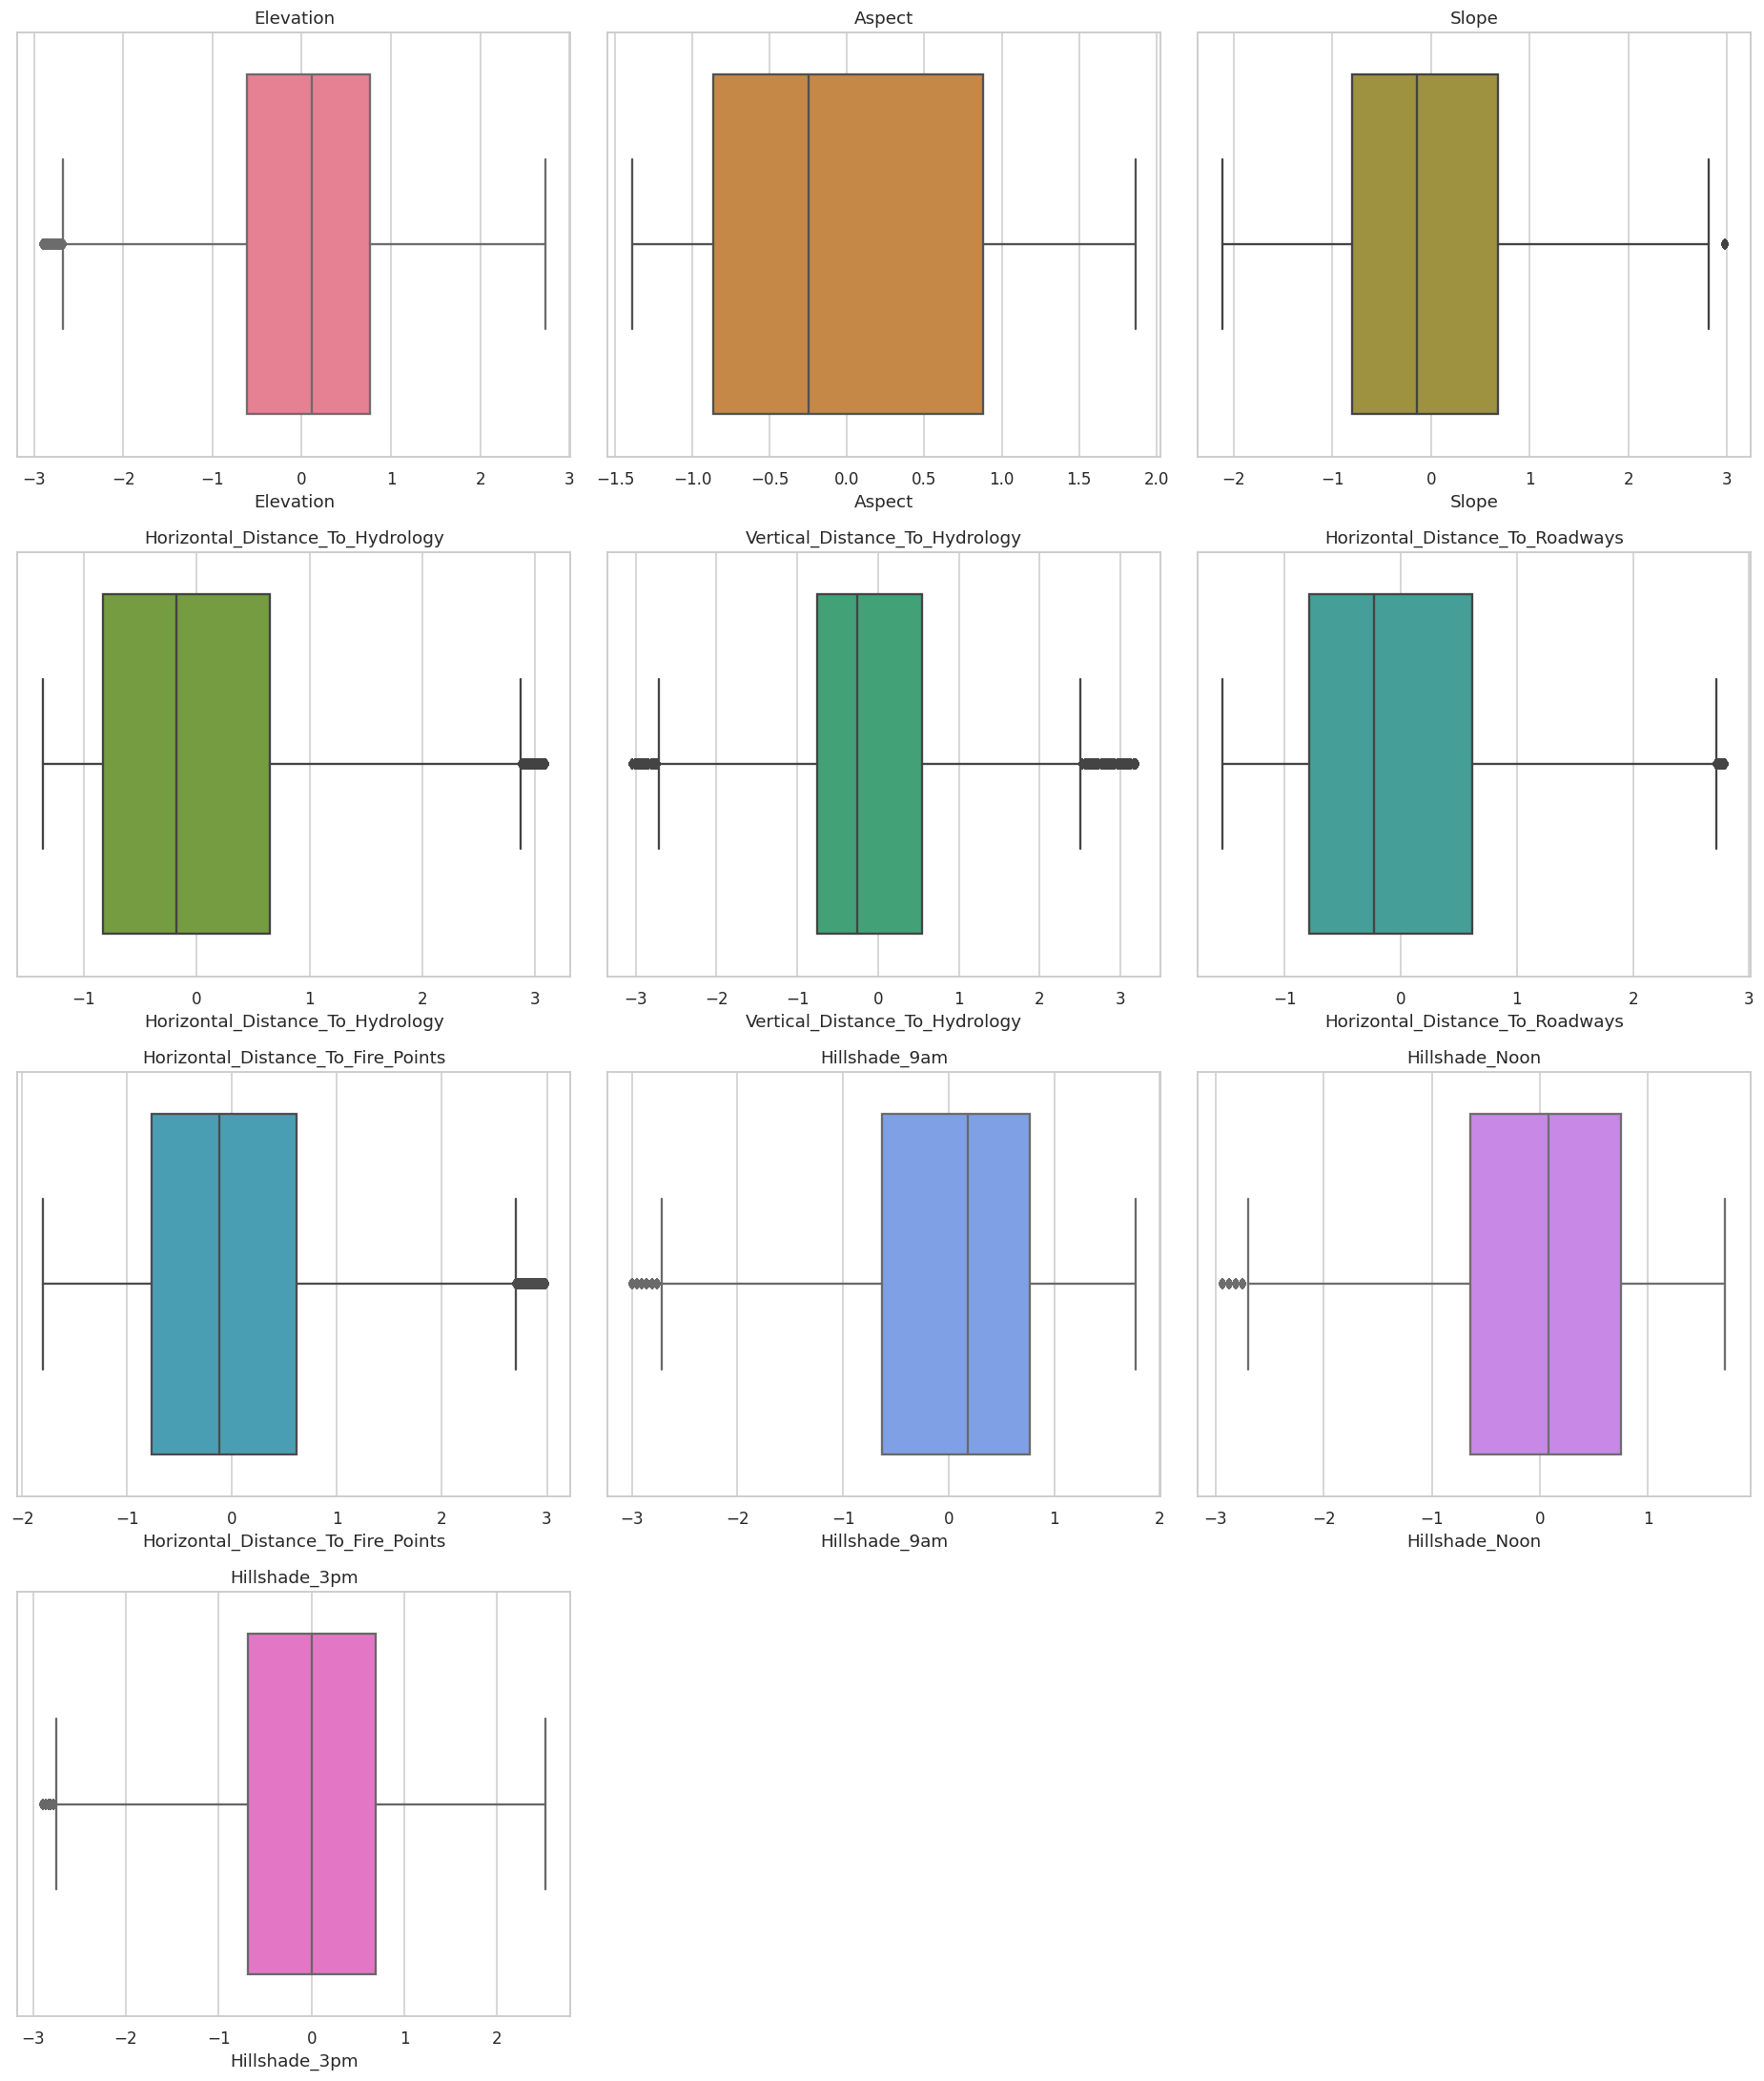

In [10]:
n = len(num_cols)
rows = math.ceil(n / 3)

plt.figure(figsize=(17, 5 * rows))

for i, col in enumerate(num_cols, 1):
    plt.subplot(rows, 3, i)
    sns.boxplot(x=df[col], color=sns.color_palette("husl", n)[i-1])
    plt.title(col)

plt.tight_layout()
plt.show()


## Plot 9 — Scatter Plot: Elevation vs Distance to Roadways

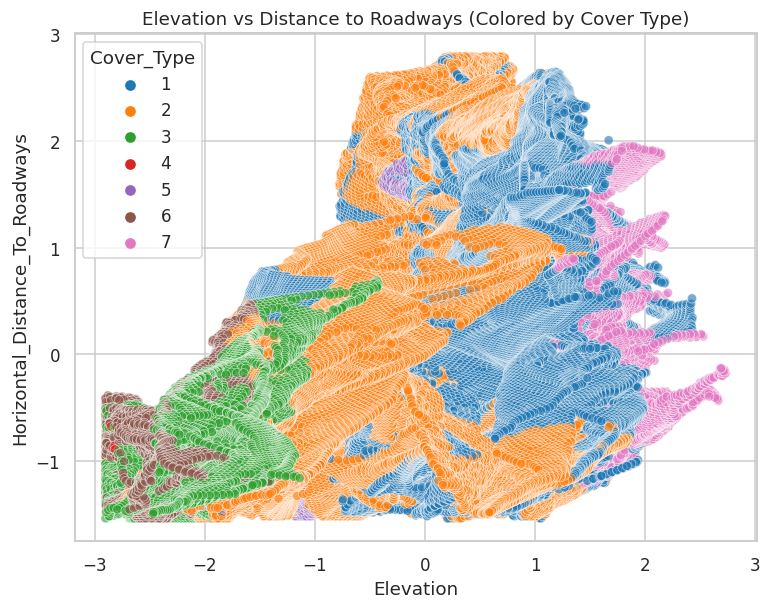

In [11]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df, x="Elevation", y="Horizontal_Distance_To_Roadways",
    hue=target_col, palette="tab10", alpha=0.6
)
plt.title("Elevation vs Distance to Roadways (Colored by Cover Type)")
plt.show()


## Plot 10 — Hillshade Relationship Plot

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


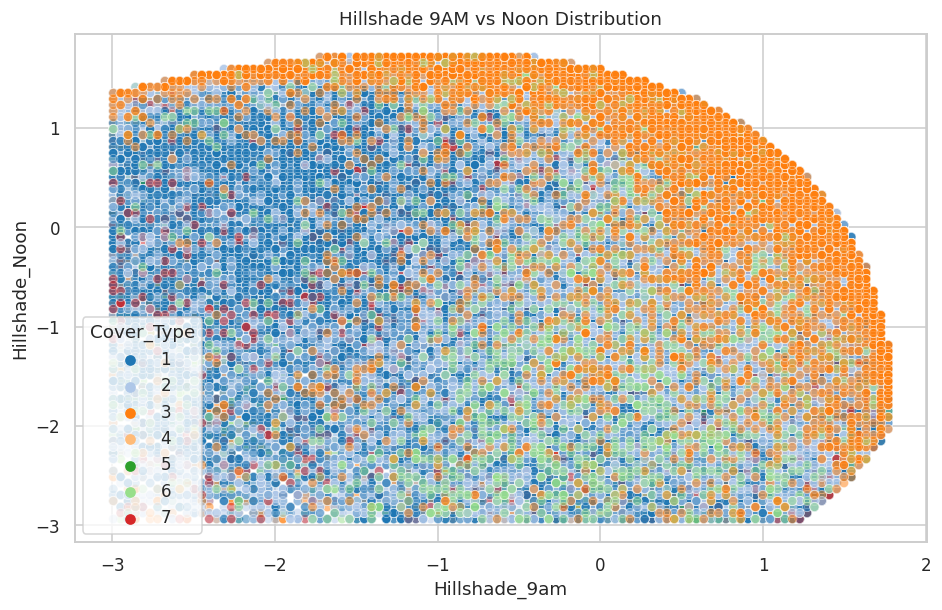

In [12]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df, x="Hillshade_9am", y="Hillshade_Noon",
    hue=target_col, palette="tab20", alpha=0.5
)
plt.title("Hillshade 9AM vs Noon Distribution")
plt.show()

## Plot 11 — Slope vs Hydrology Distance

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


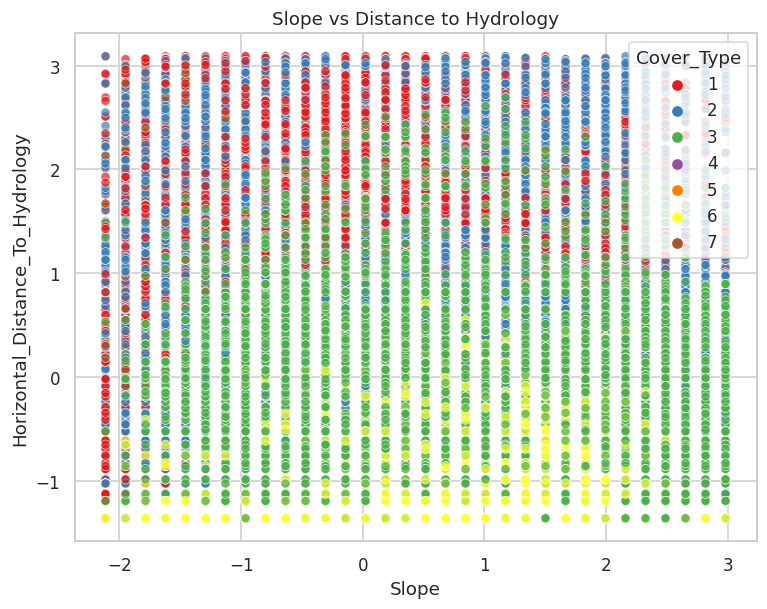

In [13]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df, x="Slope", y="Horizontal_Distance_To_Hydrology",
    hue=target_col, palette="Set1", alpha=0.7
)
plt.title("Slope vs Distance to Hydrology")
plt.show()


## Plot 12 — Violin Plot

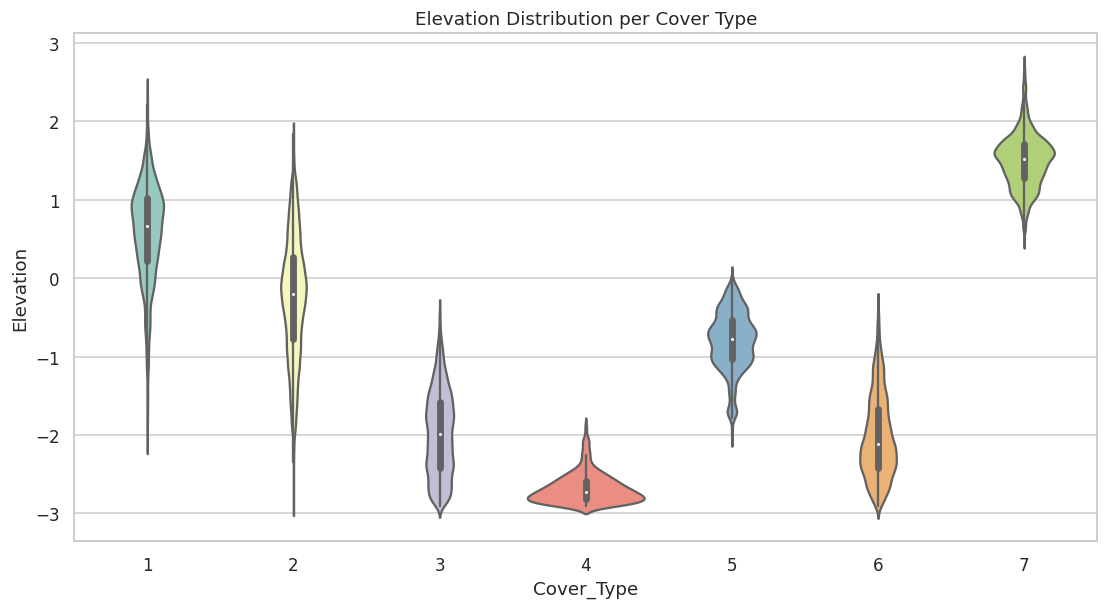

In [14]:
plt.figure(figsize=(12,6))
sns.violinplot(data=df, x=target_col, y="Elevation", palette="Set3")
plt.title("Elevation Distribution per Cover Type")
plt.show()
